# Trabajo Mineria

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# Cargar los archivos CSV
sueldo_df = pd.read_csv("sueldo_minimo_chile.csv")           # 2009 a 2025
desempleo_df = pd.read_csv("Tasa desempleo.csv")               # 2010 a 2024 trimestres
empleo_df = pd.read_csv("tasa_empleo_formal_etario.csv")        # 2010 a 2024 trimestres
empleo_informal_df = pd.read_csv("tasa_empleo_informal_etario.csv")  # 2017 a 2024 trimestres
sueldo_nominal = pd.read_csv("sueldo_nominal_etario.csv")       # Anual 2010 a 2022
pib_percapita = pd.read_csv("Pib_percapita.csv")                # Anual 1960 a 2023 (el más útil)
dolar = pd.read_csv("dolar.csv", sep=";")                       # Mensual 2007 a 2025
ipc = pd.read_csv("ipc.csv", encoding="latin", sep=";")         # Mensual 2010 a 2025 (2023=100)

# Renombrar la columna "Índice" a "ipc" en el DataFrame de IPC
ipc = ipc.rename(columns={"Índice": "ipc"})

# Definir listas y claves de merge (no se usan directamente, pero aquí se mantienen para referencia)
lista = ["Trimestre Móvil", "Tramo etario", "Value"]
merge_keys = ["Trimestre Móvil", "Tramo etario"]

# Fusionar los DataFrames de empleo formal y desempleo por "Trimestre Móvil" y "Tramo etario"
df_empleabilidad = pd.merge(
    empleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    desempleo_df[["Trimestre Móvil", "Tramo etario", "Value"]],
    on=["Trimestre Móvil", "Tramo etario"],
    how="inner"
)

# Renombrar columnas para mayor claridad
df_empleabilidad = df_empleabilidad.rename(columns={
    "Value_x": "Tasa de empleo",
    "Value_y": "Tasa de desempleo"
})

# Extraer el año a partir de la columna "Trimestre Móvil"
df_empleabilidad["Año"] = df_empleabilidad["Trimestre Móvil"].str.extract(r"(\d{4})").astype(int)

# Diccionario para mapear abreviaturas de meses a números
meses = {
    "ene": 1, "feb": 2, "mar": 3, "abr": 4, "may": 5, "jun": 6,
    "jul": 7, "ago": 8, "sep": 9, "oct": 10, "nov": 11, "dic": 12
}

# Extraer el mes desde la columna "Trimestre Móvil" (se toma la parte de caracteres que representa el mes)
df_empleabilidad["Mes"] = df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)

# Ajustar el año para los registros de enero, suponiendo que en ese caso corresponde al año siguiente
df_empleabilidad.loc[df_empleabilidad['Mes'] == 1, 'Año'] = df_empleabilidad[df_empleabilidad["Mes"] == 1]["Año"] + 1

# Procesar el DataFrame de sueldo mínimo:
# Convertir la columna "fecha" a datetime, reindexar con un rango completo y rellenar valores faltantes
sueldo_df["fecha"] = pd.to_datetime(sueldo_df["fecha"], errors='coerce')
date_range = pd.date_range(start="2009-07-01", end="2025-05-01", freq='MS')
sueldo_df = sueldo_df.set_index("fecha").reindex(date_range).reset_index().ffill().rename(columns={"index": "fecha"})

# Extraer el año y el mes para realizar los merges
sueldo_df['Año'] = sueldo_df['fecha'].dt.year
sueldo_df['Mes'] = sueldo_df['fecha'].dt.month
sueldo_df = sueldo_df.rename(columns={"monto_clp": "Sueldo minimo"})

# Fusionar df_empleabilidad con sueldo_df por "Año" y "Mes"
df_empleabilidad = pd.merge(
    df_empleabilidad[["Año", "Mes", "Tramo etario", "Tasa de empleo", "Tasa de desempleo"]],
    sueldo_df[["Año", "Mes", "Sueldo minimo"]],
    on=["Año", "Mes"],
    how="inner"
)

# Fusionar con el DataFrame de IPC (ya renombrado a "ipc")
df_empleabilidad = pd.merge(
    df_empleabilidad,
    ipc[["Año", "Mes", "ipc"]],
    on=["Año", "Mes"],
    how="inner"
)

# Procesar el DataFrame del dólar
# Extraer el mes (de las primeras tres letras) y el año desde la columna "Periodo"
dolar["Mes"] = dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)
dolar["Año"] = dolar["Periodo"].str.extract(r"(\d{4})").astype(int)

# Fusionar con el DataFrame de dólar
df_empleabilidad = pd.merge(
    df_empleabilidad,
    dolar[["Año", "Mes", "Dólar observado"]],
    on=["Año", "Mes"],
    how="inner"
)  # Hasta 2024

# Procesar el DataFrame de PIB per cápita:
# Filtrar para Chile, eliminar columnas innecesarias, transponer y renombrar las columnas
pib_percapita = pib_percapita[pib_percapita["Country Name"] == "Chile"] \
    .drop(["Country Name", "Country Code", "Indicator Name", "Indicator Code"], axis=1) \
    .transpose().reset_index().rename(columns={"index": "Año", 39: "PIB per capita"}).dropna()
pib_percapita["Año"] = pib_percapita["Año"].astype(int)

# Fusionar con el DataFrame de empleabilidad usando el PIB per cápita (hasta 2023)
df_empleabilidad_pib = pd.merge(
    df_empleabilidad,
    pib_percapita,
    on=["Año"],
    how="inner"
)

# Fusionar con el DataFrame de sueldo nominal (hasta 2022)
df_empleabilidad_sueldo = pd.merge(
    df_empleabilidad_pib,
    sueldo_nominal[["Año", "Tramo etario", "Value"]].rename(columns={"Value": "Sueldo nominal"}),
    on=["Año", "Tramo etario"],
    how="inner"
)

# Asegurarse que los valores de "ipc" sean numéricos; se reemplazan comas por puntos para convertirlos
df_empleabilidad_sueldo["ipc"] = pd.to_numeric(
    df_empleabilidad_sueldo["ipc"].astype(str).str.replace(",", "."),
    errors='coerce'
)

# Convertir "Dólar observado" a numérico, gestionando posibles comas
df_empleabilidad_sueldo["Dólar observado"] = pd.to_numeric(
    df_empleabilidad_sueldo["Dólar observado"].astype(str).str.replace(",", "."),
    errors='coerce'
)

# Crear columna: Sueldo mínimo en USD dividiendo por el dólar observado y redondeando a 2 decimales
df_empleabilidad_sueldo["Sueldo mínimo USD"] = (
    df_empleabilidad_sueldo["Sueldo minimo"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Sueldo nominal en USD redondeado igual que el anterior
df_empleabilidad_sueldo["Sueldo nominal USD"] = (
    df_empleabilidad_sueldo["Sueldo nominal"] / df_empleabilidad_sueldo["Dólar observado"]
).round(2)

# Crear columna: Razón entre sueldo nominal y sueldo mínimo (ambos en USD) redondeado a 2 decimales
df_empleabilidad_sueldo["Razón sueldo nominal/minimo"] = (
    df_empleabilidad_sueldo["Sueldo nominal USD"] / df_empleabilidad_sueldo["Sueldo mínimo USD"]
).round(2)

# Eliminar las columnas originales de sueldos en CLP para evitar confusiones
df_empleabilidad_sueldo = df_empleabilidad_sueldo.drop(columns=["Sueldo minimo", "Sueldo nominal"])

# Crear columna Booleana para marcar el período pandémico
df_empleabilidad_sueldo["Pandemia"] = (
    ((df_empleabilidad_sueldo["Año"] > 2020) & (df_empleabilidad_sueldo["Año"] < 2022))
    | ((df_empleabilidad_sueldo["Año"] == 2020) & (df_empleabilidad_sueldo["Mes"] >= 3))
    | ((df_empleabilidad_sueldo["Año"] == 2022) & (df_empleabilidad_sueldo["Mes"] <= 12))
)

# Realizar la codificación de la variable categórica "Tramo etario" usando get_dummies
df_encoded = pd.get_dummies(df_empleabilidad_sueldo, columns=["Tramo etario"])

# Mostrar las primeras filas del DataFrame final
df_encoded

C:\Users\orteg\AppData\Local\Temp\ipykernel_4888\3587079781.py:48: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_empleabilidad["Mes"] = df_empleabilidad["Trimestre Móvil"].str.slice(start=9, stop=12).replace(meses)
C:\Users\orteg\AppData\Local\Temp\ipykernel_4888\3587079781.py:82: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dolar["Mes"] = dolar["Periodo"].str.slice(start=0, stop=3).replace(meses)


,Año,Mes,Tasa de empleo,Tasa de desempleo,ipc,Dólar observado,PIB per capita,Sueldo mínimo USD,Sueldo nominal USD,Razón sueldo nominal/minimo,Pandemia,Tramo etario_15-24 años,Tramo etario_25-34 años,Tramo etario_35-44 años,Tramo etario_45-54 años,Tramo etario_55-64 años,Tramo etario_65 años y más,Tramo etario_Total
0,2010,3,54.139000,9.227598,57.82,523.16,12632.870473,315.39,727.90,2.31,False,False,False,False,False,False,False,True
1,2010,3,30.973043,20.215636,57.82,523.16,12632.870473,315.39,381.99,1.21,False,True,False,False,False,False,False,False
2,2010,3,70.121048,10.727110,57.82,523.16,12632.870473,315.39,741.96,2.35,False,False,True,False,False,False,False,False
3,2010,3,73.710138,6.867825,57.82,523.16,12632.870473,315.39,822.37,2.61,False,False,False,True,False,False,False,False
4,2010,3,68.720825,6.300679,57.82,523.16,12632.870473,315.39,772.79,2.45,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073,2022,12,72.758222,8.969885,97.21,875.66,15451.131958,456.80,845.80,1.85,True,False,True,False,False,False,False,False
1074,2022,12,77.752721,6.646202,97.21,875.66,15451.131958,456.80,1044.13,2.29,True,False,False,True,False,False,False,False
1075,2022,12,73.267255,6.337989,97.21,875.66,15451.131958,456.80,928.40,2.03,True,False,False,False,True,False,False,False
1076,2022,12,60.654668,6.127412,97.21,875.66,15451.131958,456.80,758.34,1.66,True,False,False,False,False,True,False,False


In [9]:
df_encoded.dtypes

Año                              int32
Mes                              int64
Tasa de empleo                 float64
Tasa de desempleo              float64
ipc                            float64
Dólar observado                float64
PIB per capita                 float64
Sueldo mínimo USD              float64
Sueldo nominal USD             float64
Razón sueldo nominal/minimo    float64
Pandemia                          bool
Tramo etario_15-24 años           bool
Tramo etario_25-34 años           bool
Tramo etario_35-44 años           bool
Tramo etario_45-54 años           bool
Tramo etario_55-64 años           bool
Tramo etario_65 años y más        bool
Tramo etario_Total                bool
dtype: object

C:\Users\orteg\AppData\Local\Temp\ipykernel_4888\3127255750.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["Pandemia"] = df_total["Pandemia"].astype(int)


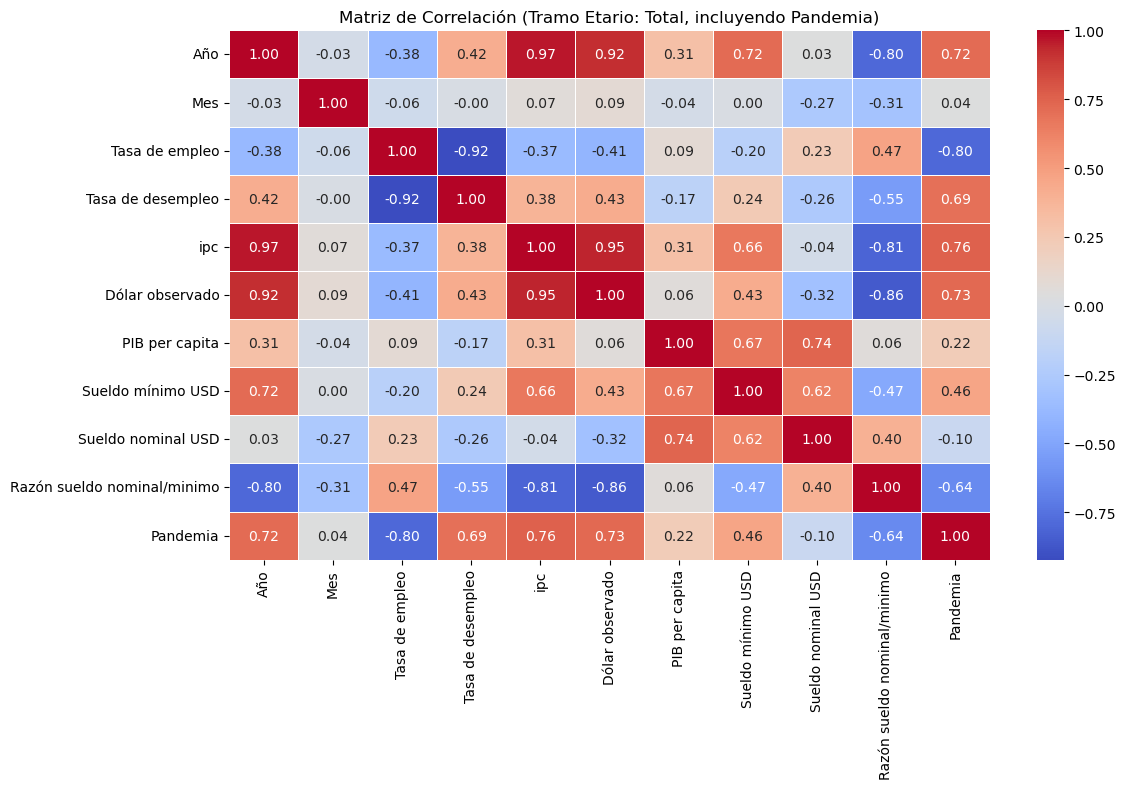

In [11]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1]

# Asegurar que la columna Pandemia esté presente y sea numérica (True -> 1, False -> 0)
if "Pandemia" in df_total.columns:
    df_total["Pandemia"] = df_total["Pandemia"].astype(int)

# Seleccionar solo columnas numéricas
df_total_numeric = df_total.select_dtypes(include="number")

# Calcular la matriz de correlación
correlation_matrix = df_total_numeric.corr()

# Visualizar con un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlación (Tramo Etario: Total, incluyendo Pandemia)")
plt.tight_layout()
plt.show()

C:\Users\orteg\AppData\Local\Temp\ipykernel_19772\1399434126.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["Pandemia"] = df_total["Pandemia"].astype(bool)


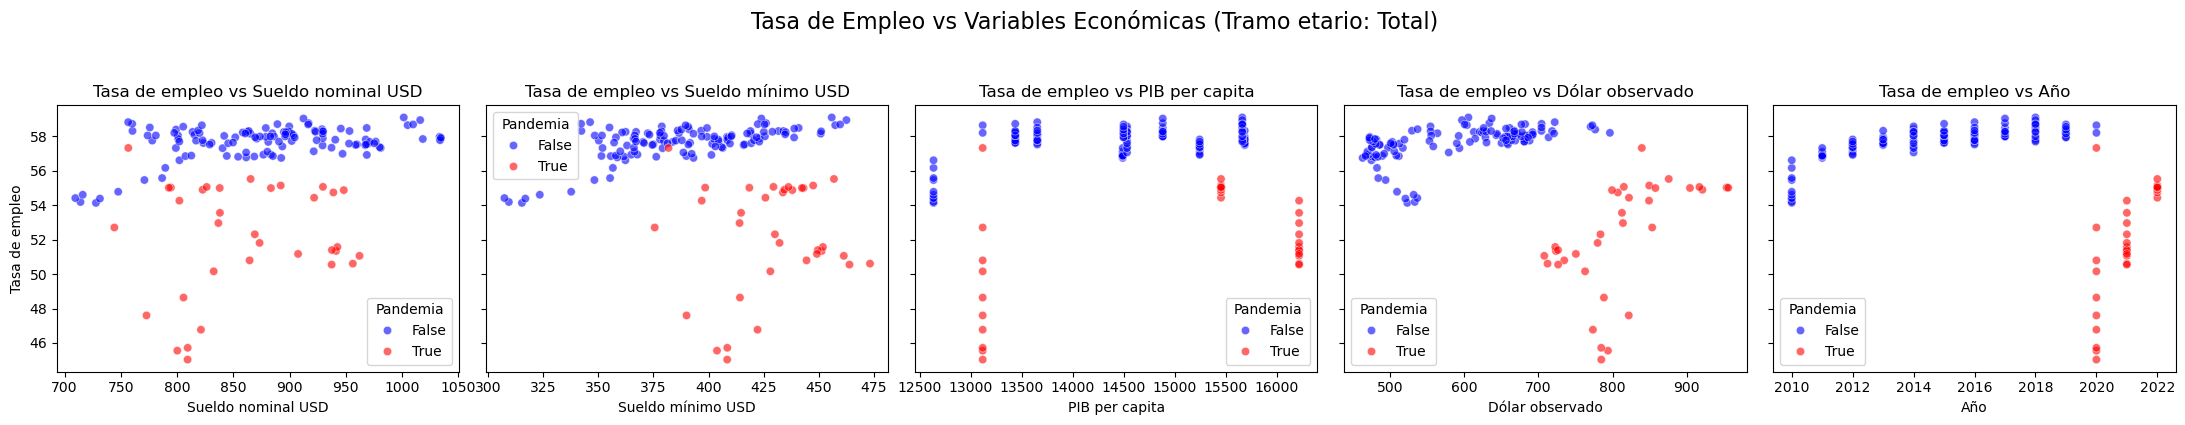

In [117]:
# Filtrar solo las filas donde el tramo etario sea "Total"
df_total = df_encoded[df_encoded["Tramo etario_Total"] == 1]

# Asegurarse que la columna Pandemia esté y sea booleana
if "Pandemia" in df_total.columns:
    df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Columnas de interés
x_vars = [
    "Sueldo nominal USD",
    "Sueldo mínimo USD",
    "PIB per capita",
    "Dólar observado",
    "Año"
]
y_var = "Tasa de empleo"

# Eliminar valores faltantes (incluyendo pandemia)
df_plot = df_total[[y_var, "Pandemia"] + x_vars].dropna()

# Crear una fila de subplots
fig, axes = plt.subplots(1, len(x_vars), figsize=(22, 4), sharey=True)

# Crear un scatterplot por variable, coloreando por pandemia
for i, var in enumerate(x_vars):
    sns.scatterplot(data=df_plot, x=var, y=y_var, hue="Pandemia", ax=axes[i], alpha=0.6, palette={True: "red", False: "blue"})
    axes[i].set_title(f"{y_var} vs {var}")
    axes[i].legend().set_title("Pandemia")

# Ajustar presentación
plt.suptitle("Tasa de Empleo vs Variables Económicas (Tramo etario: Total)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


C:\Users\orteg\AppData\Local\Temp\ipykernel_19772\4011704982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_total["Pandemia"] = df_total["Pandemia"].astype(bool)


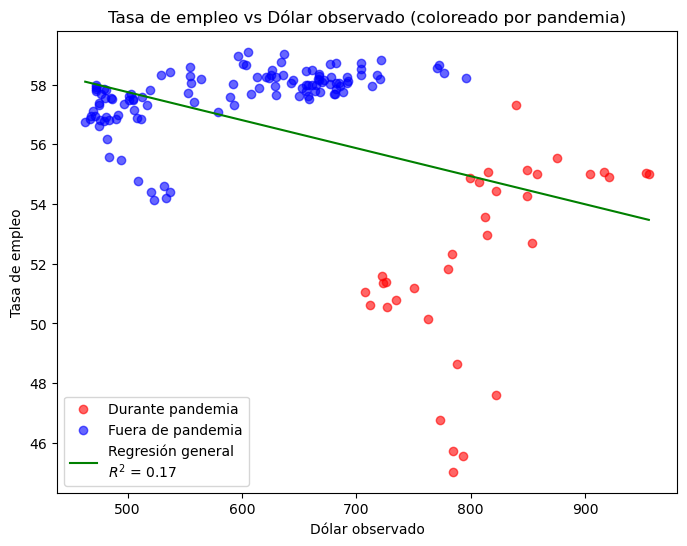

In [119]:
# Asegurar que 'Pandemia' está como columna booleana
df_total["Pandemia"] = df_total["Pandemia"].astype(bool)

# Seleccionar variables y eliminar filas con NA
df_reg = df_total[["Tasa de empleo", "Dólar observado", "Pandemia"]].dropna()

X = df_reg["Dólar observado"].values.reshape(-1, 1)
y = df_reg["Tasa de empleo"].values
pandemia = df_reg["Pandemia"].values

# Crear y entrenar modelo general
model = LinearRegression()
model.fit(X, y)
X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_fit = model.predict(X_fit)

# Graficar con color por pandemia
plt.figure(figsize=(8, 6))
plt.scatter(X[pandemia], y[pandemia], color='red', alpha=0.6, label="Durante pandemia")
plt.scatter(X[~pandemia], y[~pandemia], color='blue', alpha=0.6, label="Fuera de pandemia")
plt.plot(X_fit, y_fit, color='green', label=f"Regresión general\n$R^2$ = {model.score(X, y):.2f}")
plt.xlabel("Dólar observado")
plt.ylabel("Tasa de empleo")
plt.title("Tasa de empleo vs Dólar observado (coloreado por pandemia)")
plt.legend()
plt.show()
